ГИПОТЕЗЫ ДЛЯ ПРОВЕРКИ:

Гипотеза 1:
    По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

Гипотеза 2:
    Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

Гипотеза 3:
    Если пользователь сначала выбирает сложность, будет ли он потом проходить обучение?

ЦЕЛЬ:
Исследовать поведение пользователей в обновлённом приложении.

ЗАДАЧИ:

    1. Определить, насколько обучение сокращает время прохождения этапов игры.
    2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
    3. Определить, насколько прозрачен процесс взаимодействия с игрой.

ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ:

    1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.

    2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

    3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

ПОДГОТОВКА ДАННЫХ К АНАЛИЗУ

In [312]:
# Подгружаем библиотеку Pandas.
import pandas as pd

# Считываем таблицы с данными.
events  = pd.read_csv('c:/IDE/gd/7_4_Events.csv', sep=',')
purchase = pd.read_csv('c:/IDE/gd/7_4_Purchase.csv', sep=',')

# Приводим данные к нужным типам.
events['tutorial_id'] = events['tutorial_id'].astype('Int64')
events['start_time'] = pd.to_datetime(events['start_time'], errors='coerce')
purchase['event_datetime'] = pd.to_datetime(purchase['event_datetime'], errors='coerce')

# Получаем список пользователей, зарегестрированных в 2018 году.
mask_2018 = (events['start_time']>='2018-01-01') & (events['start_time']<'2019-01-01')
mask_registration = events['event_type'] == 'registration'
userID_2018 = events[mask_registration & mask_2018]['user_id'].to_list()

# Фильтруем данные, чтобы остались только пользователи, зарегестрированные в 2018 году.
events = events[events['user_id'].isin(userID_2018)]
purchase = purchase[purchase['user_id'].isin(userID_2018)]

events.info()
purchase.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              66959 non-null  int64         
 1   event_type      66959 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      66959 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  Int64         
 5   user_id         66959 non-null  int64         
dtypes: Int64(1), datetime64[ns](1), int64(2), object(2)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1600 non-null   int64         
 1   user_id         1600 non-null   int64         
 2   event_datetime  1600 non-null   datetime64[ns]
 3   amount          1600 non-nul

In [313]:
# Переименовываем колонки для объединения датафреймов.
events = events.rename(columns={'id': 'event_id'})
purchase = purchase.rename(columns={'id': 'purchase_id', 'event_datetime': 'start_time'})

# В таблице purchase добавляем колонку event_type.
purchase['event_type'] = 'purchase'

# Объединяем таблицы.
total_events = pd.concat([events,purchase],sort=False)
display(total_events.head())

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
51405,80308.0,registration,NaN,2018-01-01 03:48:40,<NA>,27832,NaN,NaN
51406,80309.0,registration,NaN,2018-01-01 04:07:25,<NA>,27833,NaN,NaN
51407,80310.0,registration,NaN,2018-01-01 08:35:10,<NA>,27834,NaN,NaN
51408,80311.0,registration,NaN,2018-01-01 11:54:47,<NA>,27835,NaN,NaN
51409,80312.0,registration,NaN,2018-01-01 13:28:07,<NA>,27836,NaN,NaN


ГИПОТЕЗА 1

Влияет ли обучение на скорость прохождения других этапов игры?

In [314]:
# Создадим сводную таблицу с временем начала каждого этапа у пользователей:
timings = total_events.pivot_table(
    values='start_time',
    index='user_id',
    columns='event_type',
    aggfunc='min'
)

display(timings.head())

event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
user_id,,,,,,
27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40


In [315]:
# Добавим в таблицу временные промежутки между этапами:
timings['registration - level_choice'] = timings['level_choice'] - timings['registration']
timings['level_choice - pack_choice'] = timings['pack_choice'] - timings['level_choice']
timings['pack_choice - purchase'] = timings['purchase'] - timings['pack_choice']
timings.reset_index(inplace = True)

display(timings.head())

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,registration - level_choice,level_choice - pack_choice,pack_choice - purchase
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,NaT,NaT,NaT
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,NaT,NaT,NaT
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,0 days 08:42:35,0 days 00:01:21,NaT
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,NaT,NaT,NaT


In [316]:
# Делим пользователей на три группы: кто начал и закончил обучение, кто начал и не закончил обучение, кто не начинал обучение.

# Пользователи, которые прошли обучение:
users_with_finished_tutorial = set(total_events[total_events["event_type"] == "tutorial_finish"]["user_id"].unique())

# Пользователи, которые начали обучени:
users_with_started_tutorial = set(total_events[total_events['event_type'] == 'tutorial_start']['user_id'].unique())

# Пользователи, которые не начинали обучение:
all_users = set(total_events['user_id'].unique())
users_without_tutorial = all_users.difference(users_with_started_tutorial)

# Функция для определения принадлежности пользователя у группе:
def users_group(user_id):
    if user_id in users_with_finished_tutorial:
        return 'trained'
    elif user_id in users_without_tutorial:
        return 'not started'
    else:
        return 'not trained'
    
#добавим в датафрейм признак с группой у пользователей
timings['users_group'] = timings.user_id.apply(users_group)

display(timings.head())

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,registration - level_choice,level_choice - pack_choice,pack_choice - purchase,users_group
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT,not started
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,NaT,NaT,NaT,trained
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,NaT,NaT,NaT,trained
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,0 days 08:42:35,0 days 00:01:21,NaT,trained
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,NaT,NaT,NaT,trained


In [317]:
# Определим среднее время прохождения этапов у каждой из групп пользователей:
mean_timings = timings.groupby('users_group')[
    ['registration - level_choice', 'level_choice - pack_choice', 'pack_choice - purchase']
].mean()
mean_timings /= pd.Timedelta('1 hour')
mean_timings

event_type,registration - level_choice,level_choice - pack_choice,pack_choice - purchase
users_group,,,
not started,5.259201,0.089951,100.825997
not trained,8.215987,0.084804,93.246363
trained,7.093571,0.088374,89.299900


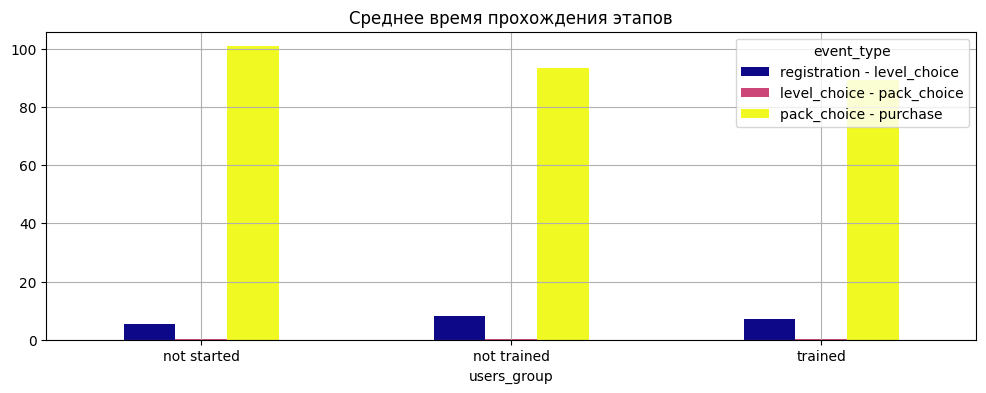

In [318]:
# Представим полученниые данные ввиде диаграммы:
import matplotlib.pyplot as plt

mean_timings.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma')
plt.xticks(rotation='horizontal')
plt.title('Среднее время прохождения этапов')
plt.show()


ГИПОТЕЗА 2

Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

In [319]:
# Считаем количество событий для каждого пользователя:
events_count = total_events.pivot_table(
    values = 'start_time',
    index = 'user_id',
    columns = 'event_type',
    aggfunc = 'count',
    fill_value = 0    
    ).reset_index()

# Группироуем таблицу по количеству попыток начала обучения, и считаем количество пользователей и клиентов в каждой из групп.
events_start = events_count.groupby(['tutorial_start'])[['registration', 'purchase']].agg('sum')
events_start = pd.DataFrame(events_start).reset_index().sort_values(by = 'tutorial_start', ascending=True)

# Считаем конверсию в покупку в каждой группе:
events_start['CR_start'] = round(events_start['purchase']/events_start['registration']*100, 2)

display(events_start)

event_type,tutorial_start,registration,purchase,CR_start
0,0,8068,22,0.27
1,1,9103,1207,13.26
2,2,1589,218,13.72
3,3,427,51,11.94
4,4,221,30,13.57
5,5,109,16,14.68
6,6,116,14,12.07
7,7,94,12,12.77
8,8,86,13,15.12
9,9,113,17,15.04


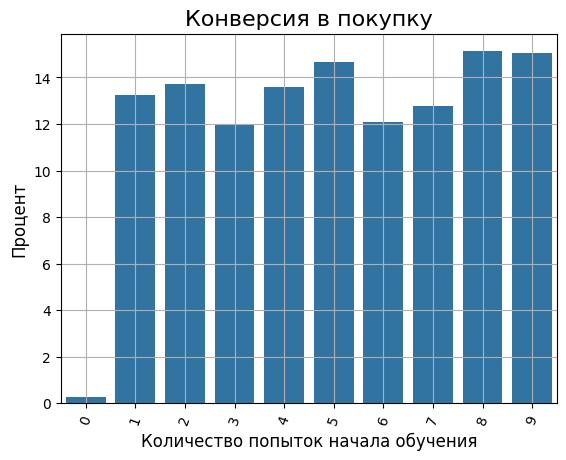

In [320]:
import seaborn as sns

barplot = sns.barplot(
    data=events_start,
    x='tutorial_start',
    y='CR_start',
    orient='v',
)
barplot.tick_params(axis='x', rotation=70);
barplot.set_title('Конверсия в покупку', fontsize=16);
barplot.set_xlabel('Количество попыток начала обучения', fontsize=12);
barplot.set_ylabel('Процент', fontsize=12);
barplot.grid()

ГИПОТЕЗА 3

Если пользователь сначала выбирает сложность, будет ли он потом проходить обучение?

In [321]:
# Формируем сводную таблицу по самому позднему времени прохождения этапа:
user_time_table_max = total_events.pivot_table (values = 'start_time', 
                                               index = 'user_id',
                                               columns = 'event_type', 
                                               aggfunc = 'max')
user_time_table_max.reset_index(inplace = True)
user_time_table_max.columns = ['user_id', 'level_choice', 'pack_choice', 'purchase', 'registration', 'tutorial_finish', 'tutorial_start']

# Фильтруем таблицу, оставив только тех пользователей, у которых время прохождения обучения больше, чем время выбора уровня сложности:
user_time_table_thesis = user_time_table_max.loc[user_time_table_max['tutorial_start'] > user_time_table_max['level_choice']]

# Для сравнения считаем, сколько у нас зарегистрированных пользователей:
registered_users_count = total_events[total_events["event_type"] == "registration"][
    "user_id"
].nunique()

# Введем такую же переменную для пользователей, которые выбрали уровень сложности:
level_choice_users_count =  total_events[ total_events["event_type"] == "level_choice"][
    "user_id"
].nunique()

# Считаем процент людей, у которых время прохождения обучения больше, чем время выбора уровня сложности,
# по отношению ко всем зарегистрированным пользователям:
percent_for_thesis = round(user_time_table_thesis["user_id"].nunique()/registered_users_count*100, 2)
print(
    "Процент пользователей, начавших обучение после выбора уровня сложности (от общего числа зарегистрировавшихся): {}%".format(
        percent_for_thesis
    )
)

# Считаем процент людей, у которых время прохождения обучения больше, чем время выбора уровня сложности,
# по отношению к пользователям, которые выбрали уровень сложности:
percent_confirmed_from_level_choice = round(user_time_table_thesis["user_id"].nunique()/level_choice_users_count*100, 2)
print(
    "Процент пользователей, начавших обучение после выбора уровня сложности (от общего числа выбравших уровень): {}%".format(
        percent_confirmed_from_level_choice
    )
)

Процент пользователей, начавших обучение после выбора уровня сложности (от общего числа зарегистрировавшихся): 6.96%
Процент пользователей, начавших обучение после выбора уровня сложности (от общего числа выбравших уровень): 16.61%


In [322]:
# Для каждого пользователя создаем список, который содержит во временной последовательности все события пользователя:
user_path_df = (
    total_events.groupby(["user_id"])["event_type"].apply(list).reset_index()
)

# Преобразуем список событий в строку event_path:
user_path_df["event_path"] = user_path_df["event_type"].apply(lambda x: " > ".join(x))

# Группируем таблицу по столбцу event_path, подсчитав число пользователей:
user_paths = (
    user_path_df.groupby(["event_path"])["user_id"]
    .nunique()
    .sort_values(ascending=False)
)

# Выбираем пути, где сначала идет выбор уровня сложности, а потом обучение:
user_paths[user_paths.index.str.contains('level_choice > tutorial_start')]

event_path
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish                                                                                                                                                                                                                                                         169
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start                                                                                                                                                                                                                                                                            39
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish                                                                                                                                                             

In [323]:
# Выбираем пути, где сначала идет выбор уровня сложности, а потом обучение:
user_paths[user_paths.index.str.contains('registration > level_choice > tutorial_start')]

Series([], Name: user_id, dtype: int64)

ВЫВОДЫ

    По гипотезе 1: Пользователи, закончившие обучение, тратят меньше времени на переход к выбору уровня сложности, и больше — на выбор бесплатного пакета вопросов и оплату. 

    По гипотезе 2: Повторное обучение положительно влияет на оплату.
    
    По гипотезе 3: Людей, которые сначала выбрали уровень сложности, а потом перешли к обучению, действительно нет (нет такого пути). Однако достаточное количество людей, пройдя обучение и выбрав уровень сложности, вернулась к обучению снова. Это говорит нам о том, что, возможно, обучение недостаточно информативно. Стоит более пристально рассмотреть количество возвращающихся к обучению для полноценных выводов.